In [300]:
# Load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [301]:
data = pd.read_csv('per_station/519.csv')
print('Len', len(data))
print(data.columns)

Len 4789
Index(['Unnamed: 0', 'eightd_has_available_keys', 'is_installed', 'is_renting',
       'is_returning', 'last_reported', 'num_bikes_available',
       'num_bikes_disabled', 'num_docks_available', 'num_docks_disabled',
       'station_id', 'weather_ts', 'apparentTemperature', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'nearestStormBearing',
       'nearestStormDistance', 'ozone', 'precipIntensity',
       'precipIntensityError', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'time', 'visibility', 'windBearing',
       'windSpeed', 'traffic_0_asof', 'traffic_0_distance', 'traffic_0_linkId',
       'traffic_0_speed', 'traffic_0_travel_time', 'traffic_1_asof',
       'traffic_1_distance', 'traffic_1_linkId', 'traffic_1_speed',
       'traffic_1_travel_time', 'traffic_2_asof', 'traffic_2_distance',
       'traffic_2_linkId', 'traffic_2_speed', 'traffic_2_travel_time', 'y_10m',
       'y_15m', 'y_30m', 'y_45m', 'y_60m', 'y_90m', 'y_120m'],
 

In [354]:
def parse_datetime(df):
    # Turn date columns from string to datetime64
    date_columns = [
        'last_reported',
        'traffic_0_asof',
        'traffic_1_asof',
        'traffic_2_asof'
    ]
    for c in date_columns:
        df[c] = pd.to_datetime(df[c], infer_datetime_format=True)

def scale_bikes_and_docks(data, capacity):
    data['num_bikes_available_scaled'] = data['num_bikes_available'] / capacity
    data['num_bikes_disabled_scaled'] = data['num_bikes_disabled'] / capacity
    data['num_docks_available_scaled'] = data['num_docks_available'] / capacity
    data['num_docks_disabled_scaled'] = data['num_docks_disabled'] / capacity
    
def get_time_features(df):
    df['day_of_week'] = df['last_reported'].dt.dayofweek
    df['hour_of_day'] = df['last_reported'].dt.hour + df['last_reported'].dt.minute / 60
    df['is_weekend'] = (df['day_of_week'] >= 5) * 1.0

parse_datetime(data)
scale_bikes_and_docks(data, 61)
get_time_features(data)
data_random_slice = data.iloc[np.random.permutation(len(shuffle))[:15]]
data_random_slice[[
        'last_reported', 
        'num_bikes_available_scaled', 
        'day_of_week', 
        'hour_of_day',
        'is_weekend']]

,last_reported,num_bikes_available_scaled,day_of_week,hour_of_day,is_weekend
1555,2016-10-25 15:45:56,0.098361,1,15.750000,0.0
3823,2016-11-06 13:29:48,0.196721,6,13.483333,1.0
128,2016-10-18 00:58:33,0.032787,1,0.966667,0.0
3054,2016-11-02 15:58:56,0.180328,2,15.966667,0.0
588,2016-10-20 04:33:17,0.114754,3,4.550000,0.0
1419,2016-10-24 21:24:54,0.868852,0,21.400000,0.0
2026,2016-10-27 23:03:09,0.918033,3,23.050000,0.0
3604,2016-11-05 03:17:55,0.163934,5,3.283333,1.0
1514,2016-10-25 11:24:41,0.180328,1,11.400000,0.0
3700,2016-11-05 17:58:28,0.557377,5,17.966667,1.0


traffic_0_speed good records: 3007 - mean: 15.1068207516
traffic_1_speed good records: 3842 - mean: 16.9239042166
traffic_2_speed good records: 4313 - mean: 40.4171156967


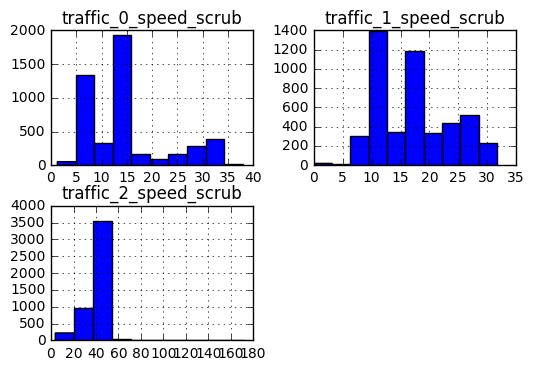

In [355]:
def set_outdated_traffic_info_to_mean(data):
    # Hide traffic information that is outdated
    limit_m = 5.0
    for i in [0, 1, 2]:
        speed_col = 'traffic_{}_speed'.format(i)
        datediff = data['last_reported'] - data['traffic_{}_asof'.format(i)]
        datediff_m = datediff / np.timedelta64(1, 'm')
        have_data = datediff_m < limit_m
        good_speeds = data[have_data][speed_col]
        mean = np.mean(good_speeds)
        print(speed_col, 'good records:', len(good_speeds), '- mean:', mean)

        speeds = data[speed_col].copy()
        speeds[~have_data] = mean
        data[speed_col + '_scrub'] = speeds

    data[['traffic_0_speed_scrub', 'traffic_1_speed_scrub', 'traffic_2_speed_scrub']].hist()
    data[['traffic_0_speed_scrub', 'traffic_1_speed_scrub', 'traffic_2_speed_scrub']].describe()
    
set_outdated_traffic_info_to_mean(data)

In [356]:
def drop_columns(data):
    return data.drop([
            'Unnamed: 0',
            'eightd_has_available_keys',
            'summary',
            'traffic_0_linkId',
            'traffic_1_linkId',
            'traffic_2_linkId',
            'traffic_0_asof', # no longer useful
            'traffic_1_asof',
            'traffic_2_asof',
            'traffic_0_speed', # unclean speeds
            'traffic_1_speed',
            'traffic_2_speed',
            'time',
            'icon',
            'weather_ts',
            'is_installed',
            'is_renting',
            'is_returning',
            'nearestStormBearing',
            'precipIntensityError',
            'precipType',
            'num_bikes_available',
            'num_docks_available',
            'num_bikes_disabled',
            'num_docks_disabled',
            'num_docks_disabled_scaled',
            
            'last_reported',
            'station_id',
            
            'traffic_0_distance',
            'traffic_1_distance',
            'traffic_2_distance',
            'traffic_0_travel_time',
            'traffic_1_travel_time',
            'traffic_2_travel_time',
            'y_10m',
            'y_15m',
            'y_30m',
            'y_45m',
            #'y_60m',
            'y_90m',
            'y_120m',
        ], axis=1)
data_drop = drop_columns(data)
print(data_drop.as_matrix().shape)
print(data_drop.columns)
data_drop[:3]

(4789, 23)
Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'nearestStormDistance', 'ozone', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'y_60m', 'num_bikes_available_scaled', 'num_bikes_disabled_scaled',
       'num_docks_available_scaled', 'day_of_week', 'traffic_0_speed_scrub',
       'traffic_1_speed_scrub', 'traffic_2_speed_scrub', 'hour_of_day',
       'is_weekend'],
      dtype='object')


,apparentTemperature,cloudCover,dewPoint,humidity,nearestStormDistance,ozone,precipIntensity,precipProbability,pressure,temperature,...,y_60m,num_bikes_available_scaled,num_bikes_disabled_scaled,num_docks_available_scaled,day_of_week,traffic_0_speed_scrub,traffic_1_speed_scrub,traffic_2_speed_scrub,hour_of_day,is_weekend
0,77.33,0.51,62.13,0.60,16,280.78,0.0,0.0,1013.38,77.33,...,0.196429,0.098361,0.081967,0.819672,0,24.230000,16.160000,45.98,13.683333,0.0
1,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,0.250000,0.032787,0.081967,0.885246,0,27.960000,16.780000,39.77,13.816667,0.0
2,78.04,0.25,62.26,0.58,39,280.50,0.0,0.0,1013.28,78.04,...,0.214286,0.098361,0.081967,0.819672,0,15.106821,16.923904,44.74,13.900000,0.0


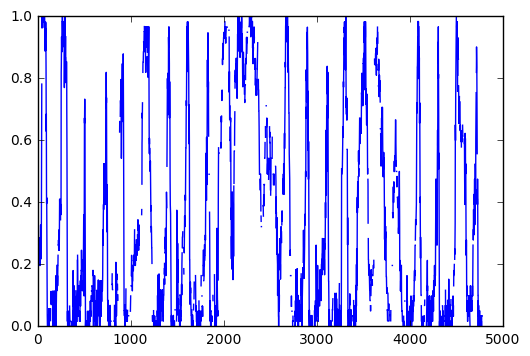

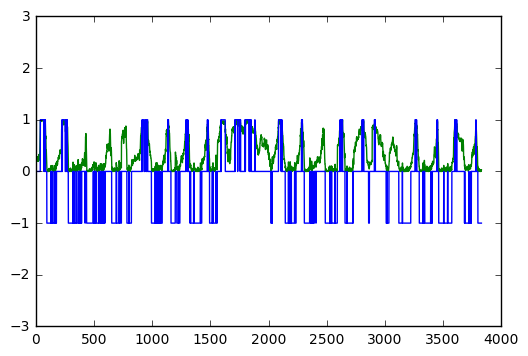

Cleaned data size: 3832


,count,mean,std,min,25%,50%,75%,max
apparentTemperature,3832.0,56.968411,10.669506,31.560000,50.210000,56.280000,65.590000,84.620000
cloudCover,3832.0,0.342756,0.304348,0.000000,0.080000,0.260000,0.560000,1.000000
dewPoint,3832.0,44.664653,11.671458,24.970000,34.805000,42.195000,55.090000,68.490000
humidity,3832.0,0.629105,0.140517,0.350000,0.520000,0.610000,0.720000,0.950000
nearestStormDistance,3832.0,73.985647,130.291373,0.000000,7.000000,19.000000,66.500000,829.000000
ozone,3832.0,279.242067,13.675113,246.790000,270.525000,276.630000,287.205000,315.310000
precipIntensity,3832.0,0.001480,0.012651,0.000000,0.000000,0.000000,0.000000,0.403900
precipProbability,3832.0,0.047508,0.201815,0.000000,0.000000,0.000000,0.000000,1.000000
pressure,3832.0,1016.246975,30.282454,419.850000,1012.670000,1019.230000,1023.190000,1031.170000
temperature,3832.0,57.748022,9.631278,38.070000,50.210000,56.280000,65.590000,83.620000


In [357]:
def bucket_y_variable(data_drop, threshold_empty=.05, threshold_full=.95):
    y_60m = data_drop['y_60m'].copy()
    y_60m[y_60m < 0] = None
    plt.figure()
    plt.plot(y_60m)
    plt.show()

    data_valid = data_drop[data_drop['y_60m'] >= 0].copy()
    yvar = np.zeros(len(data_valid))
    yvar[(data_valid['y_60m'] < threshold_empty).as_matrix()] = -1
    yvar[(data_valid['y_60m'] > threshold_full).as_matrix()] = 1
    data_valid['y'] = yvar
    plt.figure()
    plt.plot(data_valid['y_60m'].as_matrix(), 'g')
    plt.plot(yvar, 'b')
    plt.ylim(-3, 3)
    plt.show()

    return data_valid.drop(['y_60m'], axis=1)

#data_cleaned = bucket_y_variable(data_drop)
data_cleaned = bucket_y_variable(data_drop, threshold_empty=0.1, threshold_full=0.9)
print('Cleaned data size:', len(data_cleaned))
data_cleaned.describe().T

In [377]:
training = data_cleaned[:2000]
dev = data_cleaned[2000:3400]
test = data_cleaned[3400:]

def make_xy(dataset):
    dX = dataset.drop('y', axis=1)
    dy = dataset['y']
    return dX, dy

training_X, training_y = make_xy(training)
dev_X, dev_y = make_xy(dev)

training_X[:3].T

,0,1,2
apparentTemperature,77.330000,78.040000,78.040000
cloudCover,0.510000,0.250000,0.250000
dewPoint,62.130000,62.260000,62.260000
humidity,0.600000,0.580000,0.580000
nearestStormDistance,16.000000,39.000000,39.000000
ozone,280.780000,280.500000,280.500000
precipIntensity,0.000000,0.000000,0.000000
precipProbability,0.000000,0.000000,0.000000
pressure,1013.380000,1013.280000,1013.280000
temperature,77.330000,78.040000,78.040000


In [380]:
def do_logreg(train_X, train_y, dev_X, dev_y, squares=False):
    
    logreg = LogisticRegression(C=1e5)
    scaler = sklearn.preprocessing.StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    
    if squares:
        train_X_scaled = np.concatenate([train_X_scaled, np.square(train_X_scaled)], axis=1)
    print('X shape:', train_X_scaled.shape)
    
    logreg.fit(train_X_scaled, train_y)

    dev_X_scaled = scaler.transform(dev_X)
    if squares:
        dev_X_scaled = np.concatenate([dev_X_scaled, np.square(dev_X_scaled)], axis=1)
        
    dev_pred = logreg.predict(dev_X_scaled)
    acc = sklearn.metrics.accuracy_score(dev_y, dev_pred)
    print('Accuracy:', acc)
    
    print(sklearn.metrics.confusion_matrix(dev_y, dev_pred))

    plt.figure()
    plt.plot(dev_y.as_matrix()[100:500], 'b')
    plt.plot(dev_pred[100:500], 'g')
    plt.plot(0.5 * (dev_y.as_matrix() - dev_pred)[100:500], 'r')
    plt.ylim(-3, 3)
    plt.show()
    
    return logreg, scaler

X shape: (2000, 22)
Accuracy: 0.632142857143
[[461  87   0]
 [310 382  80]
 [  2  36  42]]


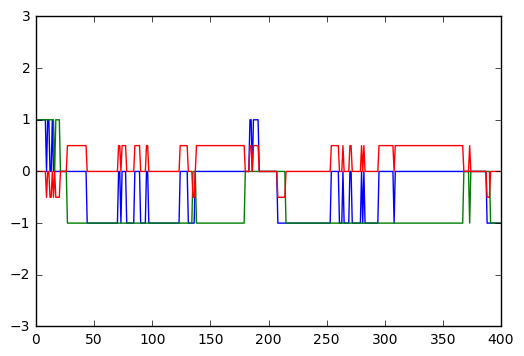

(LogisticRegression(C=100000.0, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 StandardScaler(copy=True, with_mean=True, with_std=True))

In [381]:
do_logreg(training_X, training_y, dev_X, dev_y)

In [382]:
shuffle = data_cleaned.copy()
shuffle = shuffle.iloc[np.random.permutation(len(shuffle))]
shuffle.reset_index(drop=True)

s_training = shuffle[:2000]
s_dev = shuffle[2000:3400]
s_test = shuffle[3400:]

s_training_X, s_training_y = make_xy(s_training)
s_dev_X, s_dev_y = make_xy(s_dev)

shuffle[:10]

,apparentTemperature,cloudCover,dewPoint,humidity,nearestStormDistance,ozone,precipIntensity,precipProbability,pressure,temperature,...,num_bikes_available_scaled,num_bikes_disabled_scaled,num_docks_available_scaled,day_of_week,traffic_0_speed_scrub,traffic_1_speed_scrub,traffic_2_speed_scrub,hour_of_day,is_weekend,y
2017,56.60,0.81,55.09,0.95,0,301.66,0.0486,1.00,1017.91,56.60,...,0.885246,0.049180,0.065574,3,15.106821,8.700000,39.15,22.150000,0.0,1.0
4528,45.13,0.76,43.06,0.80,17,297.74,0.0000,0.00,1013.26,49.00,...,0.836066,0.049180,0.114754,2,15.106821,19.880000,49.71,23.950000,0.0,0.0
2218,39.56,0.00,33.92,0.69,17,299.48,0.0000,0.00,1023.19,43.21,...,0.688525,0.131148,0.180328,4,19.880000,11.180000,36.04,22.983333,0.0,0.0
4409,56.31,0.63,47.92,0.73,0,284.68,0.0124,1.00,1010.71,56.31,...,0.032787,0.016393,0.950820,2,6.210000,14.910000,39.15,12.483333,0.0,-1.0
727,66.43,0.99,63.67,0.91,0,269.43,0.0036,0.31,1016.47,66.43,...,0.491803,0.000000,0.508197,3,27.960000,19.880000,39.15,20.566667,0.0,0.0
2664,51.85,0.12,34.09,0.51,0,282.63,0.0000,0.00,1022.35,51.85,...,0.573770,0.000000,0.426230,0,21.750000,21.130000,37.28,18.550000,0.0,0.0
889,69.90,0.66,66.92,0.90,8,258.27,0.0000,0.00,999.44,69.90,...,0.655738,0.032787,0.311475,4,6.840000,11.180000,31.69,18.233333,0.0,0.0
2349,60.53,0.29,49.23,0.66,15,278.39,0.0000,0.00,1013.33,60.53,...,0.770492,0.032787,0.196721,5,14.910000,16.923904,14.29,20.033333,1.0,0.0
2089,41.91,0.55,35.73,0.63,21,312.17,0.0000,0.00,1019.85,47.89,...,0.426230,0.098361,0.475410,4,6.210000,18.020000,45.98,12.066667,0.0,0.0
3714,58.22,0.15,42.33,0.55,45,279.41,0.0000,0.00,1020.93,58.22,...,0.639344,0.049180,0.311475,5,11.180000,26.100000,22.99,19.233333,1.0,0.0


X shape: (2000, 22)
Accuracy: 0.726428571429
[[392 111   0]
 [163 593  10]
 [  0  99  32]]


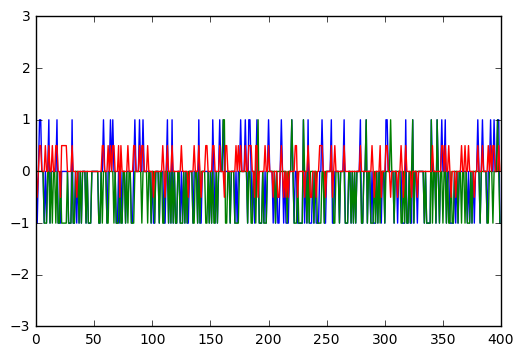

In [383]:
random_logreg, random_scaler = do_logreg(s_training_X, s_training_y, s_dev_X, s_dev_y)

In [384]:
coefs = pd.DataFrame(random_logreg.coef_.T, columns=['empty', 'intermediate', 'full'])
coefs['feature_name'] = training_X.columns
coefs

,empty,intermediate,full,feature_name
0,1.502007,-2.279616,-0.444471,apparentTemperature
1,-0.289899,0.345039,-0.474877,cloudCover
2,-7.342022,2.514511,-0.916021,dewPoint
3,4.286450,-1.447411,-0.286730,humidity
4,0.212332,-0.006340,-1.751621,nearestStormDistance
5,-0.061999,0.009725,0.679273,ozone
6,0.035353,0.080437,-0.057632,precipIntensity
7,0.099001,-0.159882,-0.712834,precipProbability
8,-0.123619,-0.157469,0.447311,pressure
9,3.921543,0.234565,1.704575,temperature


Len 517: 3095
traffic_0_speed good records: 2185 - mean: 14.5641006865
traffic_1_speed good records: 2594 - mean: 16.2804086353
traffic_2_speed good records: 2879 - mean: 39.918086141
517 drop shape: (3095, 23)


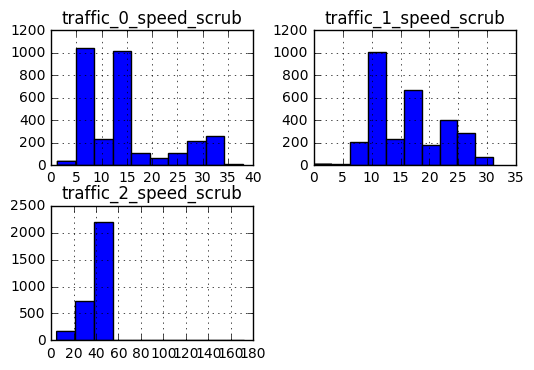

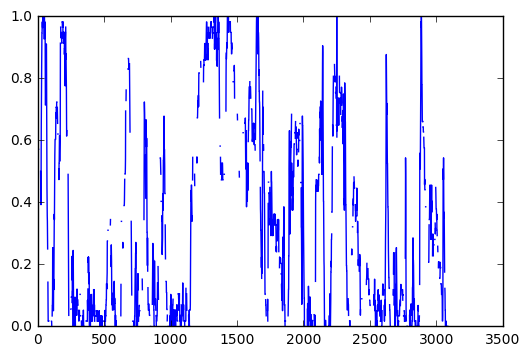

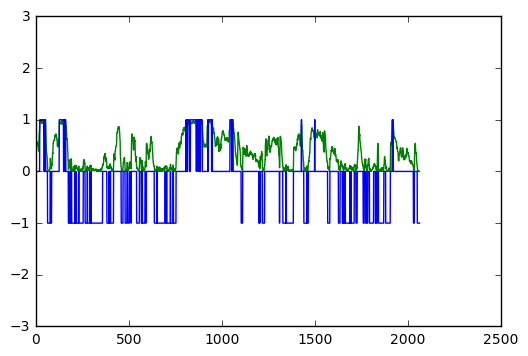

Cleaned data size (517): 2063


,count,mean,std,min,25%,50%,75%,max
apparentTemperature,2063.0,57.255468,10.696980,37.26,50.430000,56.300000,65.710000,84.620000
cloudCover,2063.0,0.322787,0.288933,0.00,0.090000,0.240000,0.500000,1.000000
dewPoint,2063.0,44.408347,11.811946,26.27,34.615000,42.180000,55.180000,68.490000
humidity,2063.0,0.617654,0.138268,0.35,0.510000,0.610000,0.700000,0.950000
nearestStormDistance,2063.0,85.552593,143.622552,0.00,8.000000,20.000000,94.000000,829.000000
ozone,2063.0,279.019636,13.829284,246.79,270.150000,276.660000,287.100000,314.970000
precipIntensity,2063.0,0.001110,0.007539,0.00,0.000000,0.000000,0.000000,0.210300
precipProbability,2063.0,0.047552,0.205358,0.00,0.000000,0.000000,0.000000,1.000000
pressure,2063.0,1017.810368,20.158800,521.67,1013.050000,1019.830000,1023.590000,1031.170000
temperature,2063.0,57.983010,9.715366,40.95,50.430000,56.300000,65.710000,83.620000


In [385]:
# Add in data from PS south (517) - capacity 59
data_517 = pd.read_csv('per_station/517.csv')
print('Len 517:', len(data_517))
parse_datetime(data_517)
get_time_features(data_517)
scale_bikes_and_docks(data_517, 61)
set_outdated_traffic_info_to_mean(data_517)
data_drop_517 = drop_columns(data_517)
print('517 drop shape:', data_drop_517.as_matrix().shape)
#data_cleaned_517 = bucket_y_variable(data_drop_517)
data_cleaned_517 = bucket_y_variable(data_drop_517, threshold_empty=0.1, threshold_full=0.9)
print('Cleaned data size (517):', len(data_cleaned_517))
data_cleaned_517.describe().T

X shape: (3000, 22)
Accuracy: 0.694285714286
[[503  45   0]
 [282 421  69]
 [  1  31  48]]


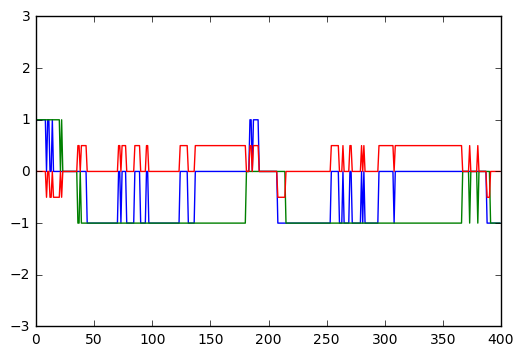

In [390]:
as_training = pd.concat([training, data_cleaned_517[training.columns][:1000]])
as_training_X, as_training_y = make_xy(as_training)

a_random_logreg, a_random_scaler = do_logreg(as_training_X, as_training_y, dev_X, dev_y)

X shape: (3000, 44)
Accuracy: 0.629285714286
[[408 140   0]
 [255 432  85]
 [  7  32  41]]


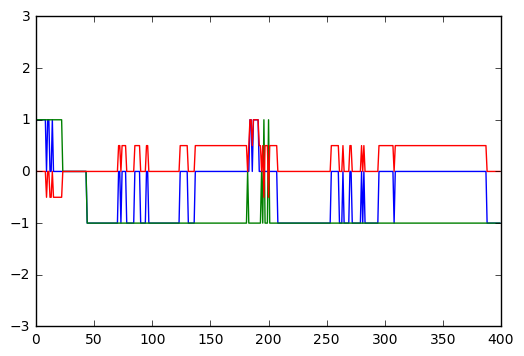

In [391]:
sq, scl = do_logreg(as_training_X, as_training_y, dev_X, dev_y, squares=True)

In [392]:
coefs = pd.DataFrame(sq.coef_.T, columns=['empty', 'intermediate', 'full'])
coefs['feature_name'] = list(training_X.columns) + [f + '^2' for f in training_X.columns]
coefs.sort_values(by=['full'], inplace=True)
coefs

,empty,intermediate,full,feature_name
30,-0.048740,-0.063802,-6.407197,pressure^2
3,-0.008020,3.105830,-5.910066,humidity
0,6.486421,-1.157415,-4.765346,apparentTemperature
9,-7.031407,6.563459,-3.834796,temperature
8,-0.480749,-1.524652,-3.824169,pressure
33,-0.034473,0.196515,-1.824943,windBearing^2
20,0.725750,0.069498,-1.683241,hour_of_day
16,-1.237462,0.214872,-1.629055,day_of_week
37,1.345045,-0.051046,-1.528216,num_docks_available_scaled^2
4,0.950672,-0.204295,-1.492063,nearestStormDistance
